# Brain Stroke Prediction

## Importing Necessary Libraries

In [276]:
import pandas as pd
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as SSSplit
from imblearn.ensemble import BalancedBaggingClassifier
from scipy.integrate import simps
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import fbeta_score
from collections import OrderedDict

In [277]:
# Check if a user gives a dataset
if not os.path.exists("config.json"):
    #Downloaded the dataset from dropbox
    if os.path.exists('brain_stroke.csv'):
        print("Alreday Present")
    else:
        os.system("wget https://www.dropbox.com/s/fpymf1avgdhx31i/brain_stroke.csv")

Alreday Present


In [278]:
#Create folder named images and models if it not exists

if not os.path.exists('images'):
    os.system("mkdir images")
else:
    #empty the image folder
    os.system("rm -rf images/*")

if not os.path.exists('models'):
    os.system("mkdir models")

## Data Visualization

In [279]:
#Reading the dataset
if os.path.exists("config.json"):
    with open("config.json","r") as f:
        file_dir=json.load(f)['filename']
        df=pd.read_csv(file_dir)
else:
    df=pd.read_csv('brain_stroke.csv')

In [280]:
#Printing the first 5 rows of the dataset
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [281]:
# Checking the null values in the dataset
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [282]:
#Printing datatypes of the columns
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [283]:
#Printing the unique values count in each column
for col in df.columns:
    print("column:  {:18s} |    unique element cnt: {}".format(col, len(np.unique(df[col]))))

column:  gender             |    unique element cnt: 2
column:  age                |    unique element cnt: 104
column:  hypertension       |    unique element cnt: 2
column:  heart_disease      |    unique element cnt: 2
column:  ever_married       |    unique element cnt: 2
column:  work_type          |    unique element cnt: 4
column:  Residence_type     |    unique element cnt: 2
column:  avg_glucose_level  |    unique element cnt: 3895
column:  bmi                |    unique element cnt: 342
column:  smoking_status     |    unique element cnt: 4
column:  stroke             |    unique element cnt: 2


In [284]:
# Using label encoder to encode the categorical columns
col_to_encode=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in col_to_encode:
    encoder=LabelEncoder()
    df[i]=encoder.fit_transform(df[i])
    print(f"{i} encoding: {dict(zip(encoder.classes_, range(len(encoder.classes_))))}")

gender encoding: {'Female': 0, 'Male': 1}
ever_married encoding: {'No': 0, 'Yes': 1}
work_type encoding: {'Govt_job': 0, 'Private': 1, 'Self-employed': 2, 'children': 3}
Residence_type encoding: {'Rural': 0, 'Urban': 1}
smoking_status encoding: {'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}


In [285]:
#Printed df.describe() 
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,0.416382,43.419859,0.096165,0.055210,0.658502,1.302349,0.508332,105.943562,28.498173,1.379442,0.049789
std,0.493008,22.662755,0.294848,0.228412,0.474260,0.860170,0.499981,45.075373,6.790464,1.072180,0.217531
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,77.230000,23.700000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,1.000000,91.850000,28.100000,2.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,2.000000,1.000000,113.860000,32.600000,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,3.000000,1.000000,271.740000,48.900000,3.000000,1.000000


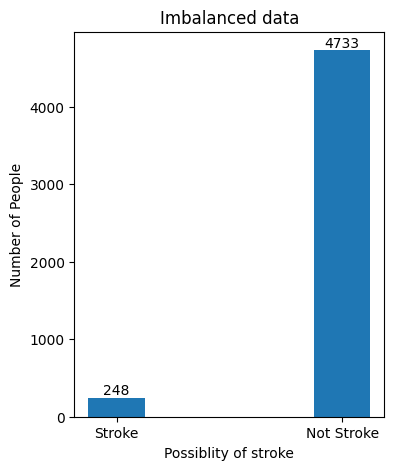

In [286]:
# Plotting possibility of stroke vs Number of peoples
height = [len(df[df["stroke"] == 1]), len(df[df["stroke"] == 0])]
plt.figure(figsize=(4, 5))
plt.bar(["Stroke","Not Stroke"],height,width = 0.25)
plt.text(0, height[0], str(height[0]), ha="center", va="bottom")
plt.text(1, height[1], str(height[1]), ha="center", va="bottom")
plt.xlabel("Possiblity of stroke")
plt.ylabel("Number of People")
plt.title("Imbalanced data")
# Saving plot image
plt.savefig('images/Imbalanced_data.png')
plt.show()


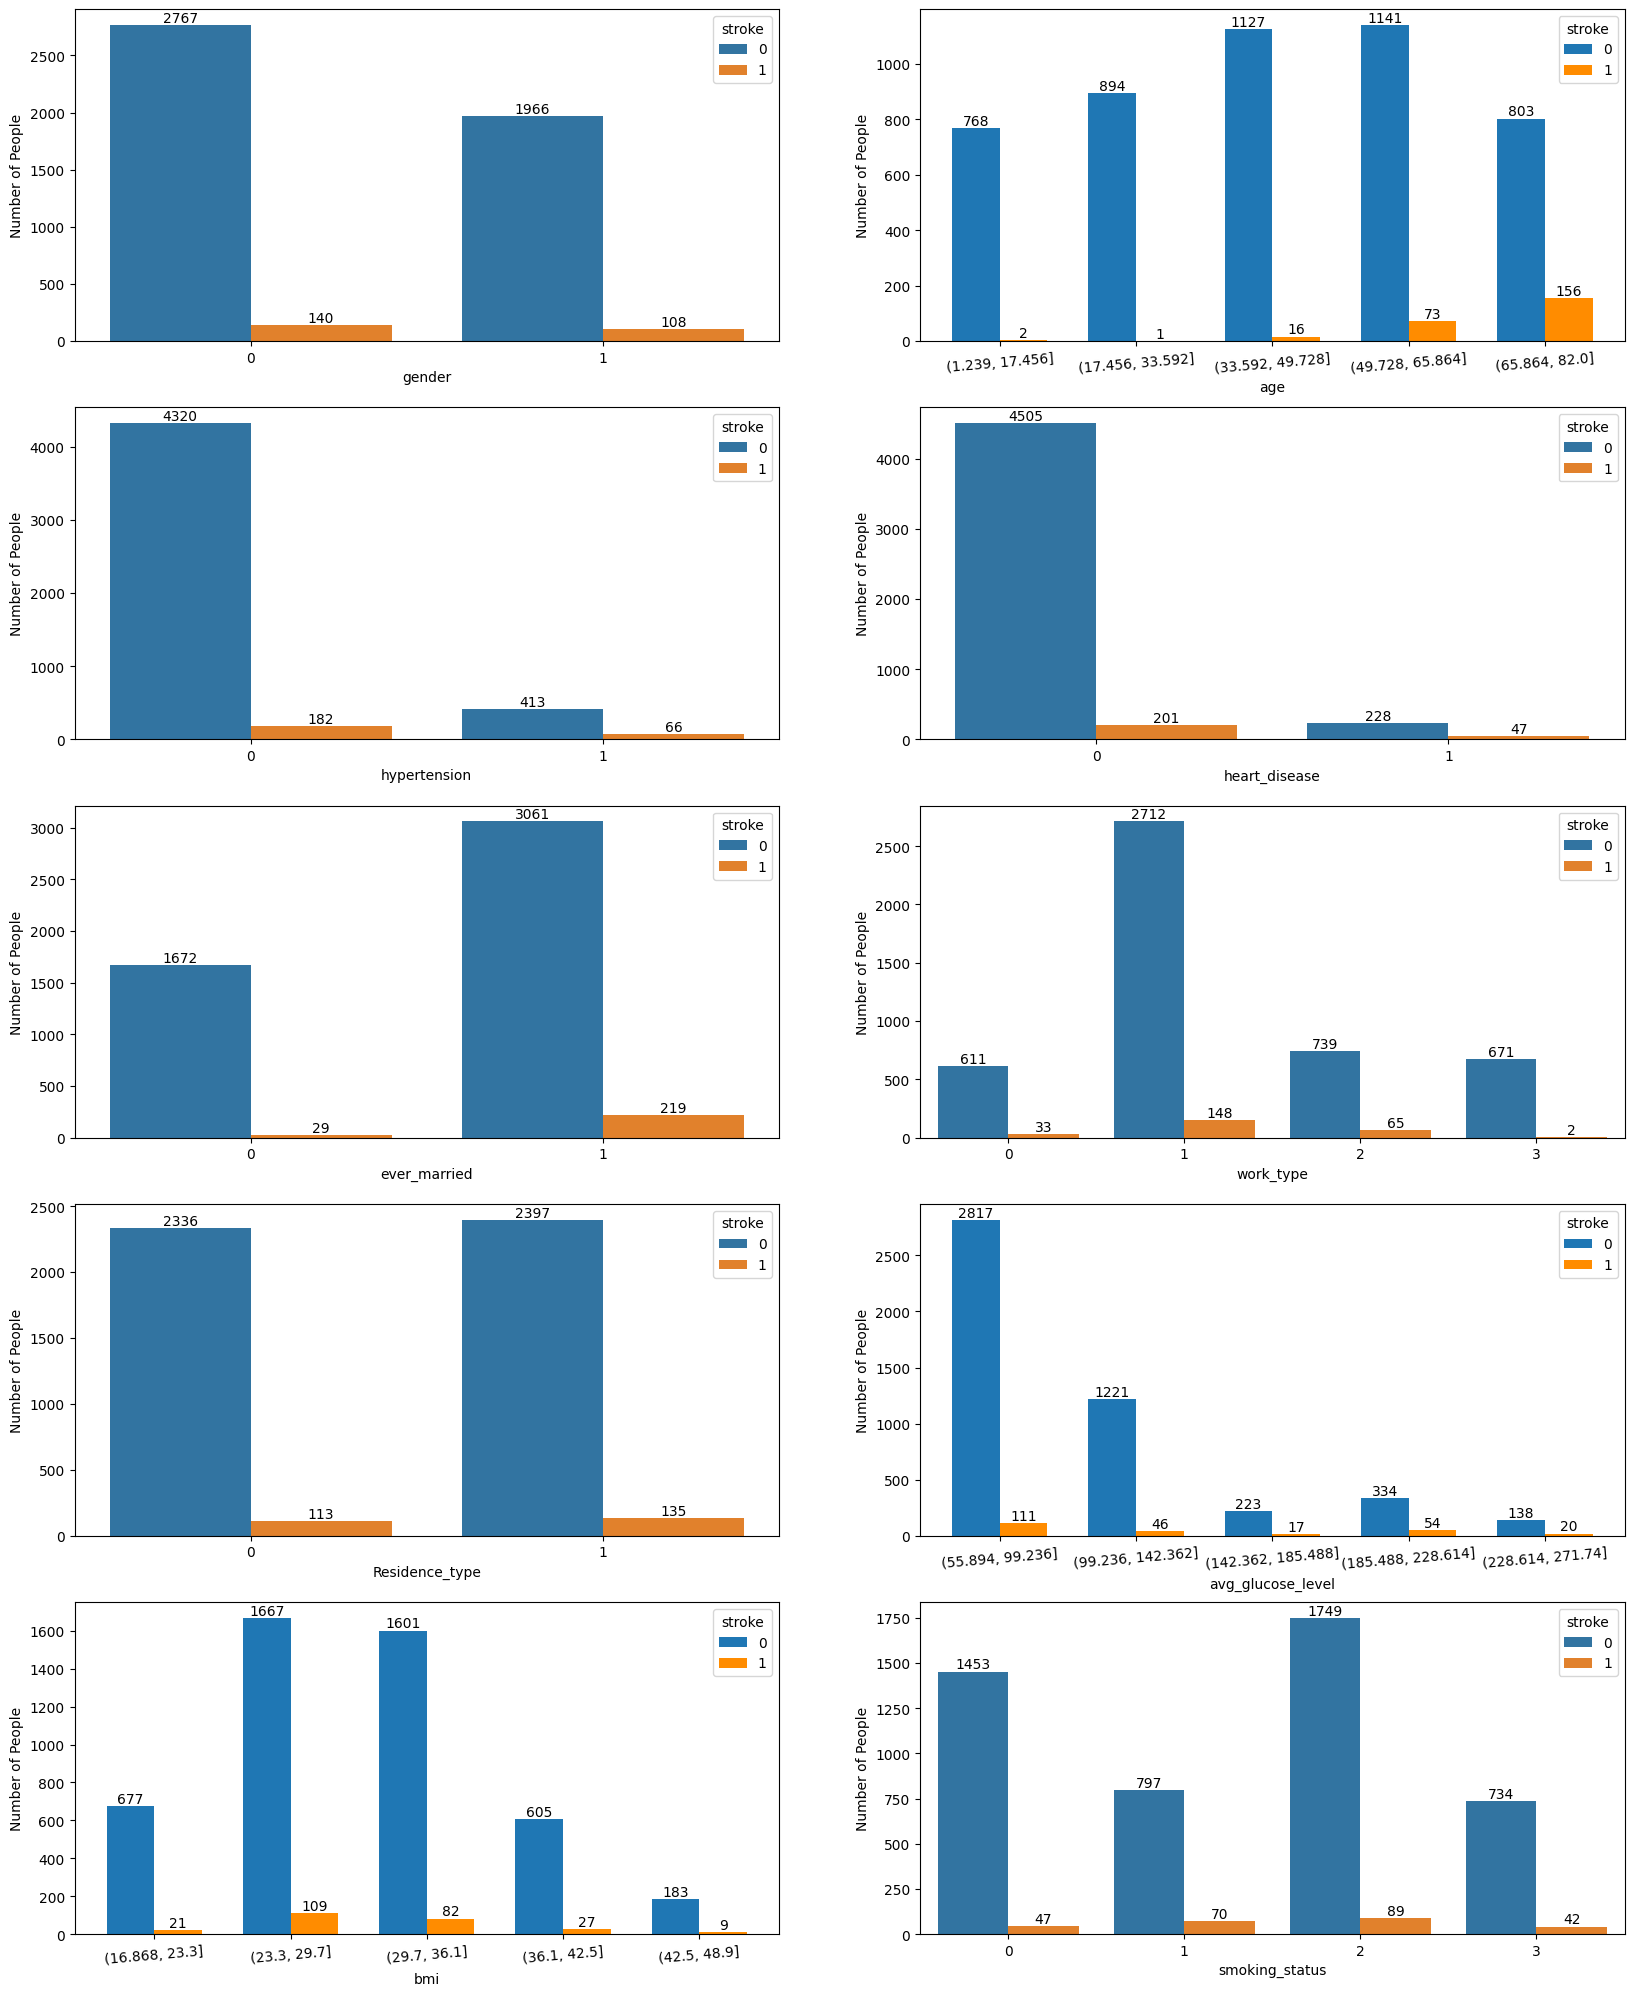

In [287]:
# Plotting variations of dataset with respect to stroke (Count Plot for each feature)
fig = plt.figure(figsize=(20, 25))
cnt = 0
temp = df
for i in df.columns[:-1]:
    if i in ["age", "avg_glucose_level", "bmi"]:
        cnt += 1
        ax = fig.add_subplot(5, 2, cnt)
        plt.xlabel(i)
        plt.ylabel("Number of People")
        bin_counts_1 = pd.cut(temp[i][temp["stroke"] == 1], bins=5).value_counts().sort_index()
        bin_counts_0 = pd.cut(temp[i][temp["stroke"] == 0], bins=5).value_counts().sort_index()
        bar_width = 0.35
        x_labels = bin_counts_1.index.values.astype(str)
        x = np.arange(len(x_labels))
        ax.bar(x - bar_width/2, bin_counts_0.values, width=bar_width, label="0",alpha = 1.0)
        ax.bar(x + bar_width/2, bin_counts_1.values, width=bar_width, label="1", color='darkorange',alpha = 1.0)
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=5)
        for j, v2, v1 in zip(x, bin_counts_1.values, bin_counts_0.values):
            ax.annotate(str(v1), xy=(j - bar_width/2, v1), ha='center', va='bottom', color='black')
            ax.annotate(str(v2), xy=(j + bar_width/2, v2), ha='center', va='bottom', color='black')
        plt.legend(title = "stroke")
    else:
        cnt += 1
        ax = fig.add_subplot(5, 2, cnt)
        sns.countplot(data=temp, x=i, hue="stroke", ax=ax)
        plt.xlabel(i)
        plt.ylabel("Number of People")
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Saving plot image
plt.savefig('images/Count_plot.png')
plt.show()

In [288]:
#Scalling the dataset
scaler = MinMaxScaler()
for col in df.columns:
    if(col!='stroke'):
        df[col] = scaler.fit_transform(np.array(df[col]).reshape(len(df[col]),1))

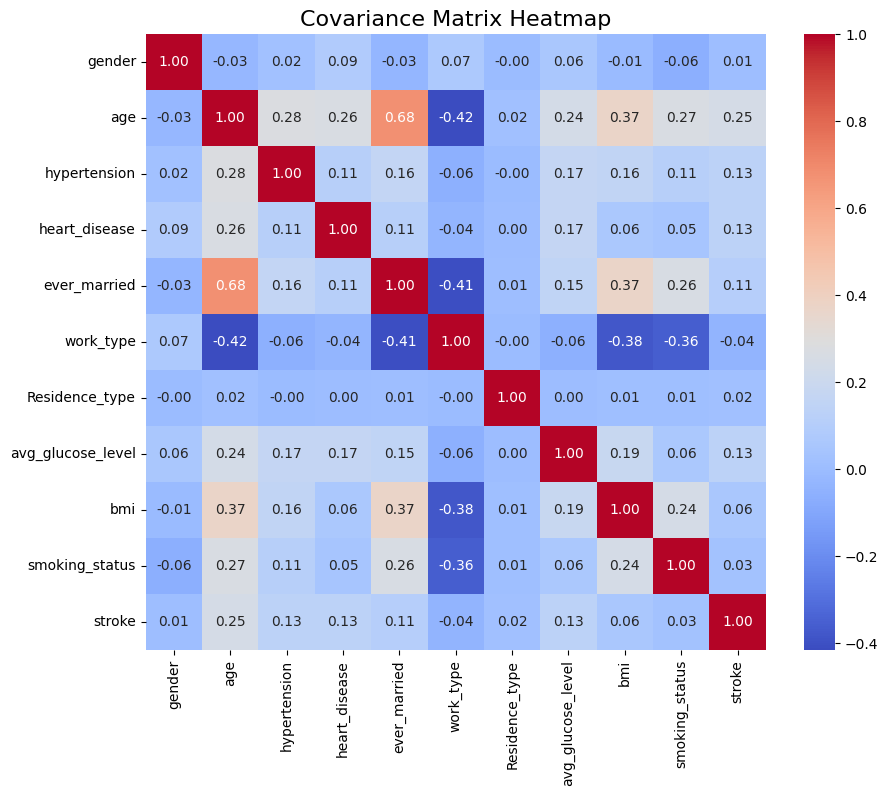

In [289]:
# Plotting correlation matrix
corr_matrix=df.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Covariance Matrix Heatmap', fontsize=16)

# Saving plot image
plt.savefig('images/Correlation_matrix.png')
# Show plot
plt.show()


In [290]:
# Splitting df into X and y
X=df.drop('stroke',axis=1).to_numpy()
y=df['stroke'].to_numpy()

In [291]:
model_selection_dict = {}
beta=2

## Splitting dat into test train and validation sets

In [292]:
# Splitting the dataset into train, validation and test set
X_train,X_temp,y_train,y_temp=tts(X,y,test_size=0.3,stratify=y)
X_val,X_test,y_val,y_test = tts(X_temp,y_temp,test_size=2/3,stratify=y_temp)
print(X_train.shape,X_val.shape)
X_train_not_sampled,y_train_not_sampled=X_train,y_train

(3486, 10) (498, 10)


## Oversampling the training data

In [293]:
# Oversampling using SMOTE
smk = SMOTETomek(sampling_strategy='minority', random_state=42)
X_train, y_train = smk.fit_resample(X_train, y_train)
print(X_train)
print("After Oversampling:")
print("Risk", Counter(y_train))

[[1.         0.12109375 0.         ... 0.20658296 0.18051576 0.33333333]
 [1.         0.14550781 0.         ... 0.04136276 0.12034384 0.        ]
 [0.         0.58496094 0.         ... 0.21369218 0.19197708 1.        ]
 ...
 [0.         0.72545334 0.         ... 0.16003062 0.44303225 0.38181754]
 [0.         0.66284217 0.         ... 0.22259758 0.32997102 0.78000146]
 [1.         0.65024717 0.         ... 0.19794324 0.44312266 1.        ]]
After Oversampling:
Risk Counter({0: 3279, 1: 3279})


In [294]:
len(X_train)

6558

## Naive Bayes

In [295]:
# Training on Naive Bayes(Complement NB)
if os.path.exists('./models/Naive Bayes(Complement).pkl'):
    CNB_clf=pickle.load(open('./models/Naive Bayes(Complement).pkl', 'rb'))
else:
    CNB_clf=ComplementNB().fit(X_train,y_train)
y_pred=CNB_clf.predict(X_val)
print("Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))
model_selection_dict["Naive Bayes(Complement)"] = fbeta_score(y_val,y_pred,beta = beta)


#Saving the Naive Bayes model
if not os.path.exists('./models/Naive Bayes(Complement).pkl'):
    pickle.dump(CNB_clf, open('./models/Naive Bayes(Complement).pkl', 'wb'))

Classification Report 

               precision    recall  f1-score   support

  not stroke       0.98      0.76      0.86       473
      stroke       0.12      0.64      0.21        25

    accuracy                           0.76       498
   macro avg       0.55      0.70      0.53       498
weighted avg       0.93      0.76      0.82       498



In [296]:
print("Confusion Matrix \n\n",confusion_matrix(y_val,y_pred))

Confusion Matrix 

 [[361 112]
 [  9  16]]


## Balanced Bagging Classifier

In [297]:
# Train on Balanced Bagging Classifier
if os.path.exists('./models/Balanced Bagging Classifier.pkl'):
    classifier_BBC=pickle.load(open('./models/Balanced Bagging Classifier.pkl', 'rb'))
else:
    classifier_BBC = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                    sampling_strategy='not majority',
                                    replacement=False,
                                    random_state=42)
classifier_BBC.fit(X_train, y_train)
preds = classifier_BBC.predict(X_val)
print("fbeta-score for Balanced Bagging Classifier is",fbeta_score(y_val,preds,beta = beta))
model_selection_dict["Balanced Bagging Classifier"] = fbeta_score(y_val,preds,beta=beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,preds,target_names=['not stroke','stroke']))

#Saving the model
if not os.path.exists('./models/Balanced Bagging Classifier.pkl'):
    pickle.dump(classifier_BBC, open('./models/Balanced Bagging Classifier.pkl', 'wb'))

fbeta-score for Balanced Bagging Classifier is 0.15037593984962405
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.95      0.94      0.95       473
      stroke       0.12      0.16      0.14        25

    accuracy                           0.90       498
   macro avg       0.54      0.55      0.54       498
weighted avg       0.91      0.90      0.91       498



In [298]:
#Function for plottting ROC curve
def plot_roc_curve(clf,X,y,classes):
    y_probas=clf.predict_proba(X)
    auc_s=[]
    for idx,class_no in enumerate(classes):
        y_true=np.where(y==class_no,1,0)
        y_probs=y_probas[:,idx]
        thresholds=np.sort(y_probs)[::-1]
        tpr=[]
        fpr=[]
        for thres in thresholds:
            y_pred=np.where(y_probs>=thres,1,0)
            tn,fp,fn,tp=confusion_matrix(y_true,y_pred).ravel()
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
        auc=np.trapz(tpr,fpr)
        auc_s.append(auc)
        plt.plot(fpr,tpr,label=class_no,alpha=0.5,lw=5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend(bbox_to_anchor=(1.15, 1.05))
    plt.show()
    print("AUC: ",auc_s)

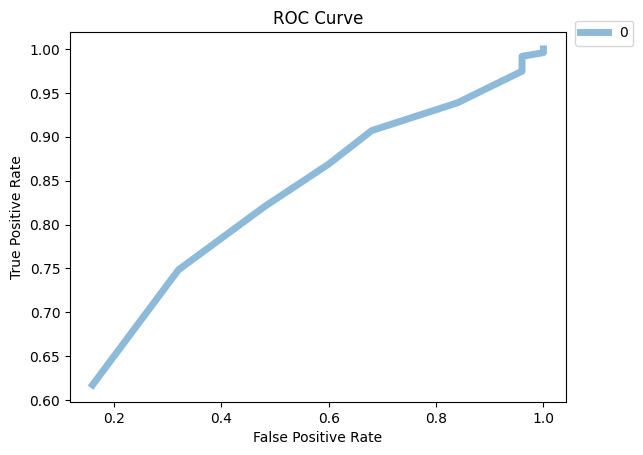

AUC:  [0.7093446088794926]


In [299]:
# Plotting ROC_curve
plot_roc_curve(classifier_BBC,X_val,y_val,[0])

In [300]:
y_prob=classifier_BBC.predict_proba(X_val)[:,1]

In [301]:
y_pred=[1 if y_proba>0.4 else 0 for y_proba in y_prob]

0.3601694915254237 0.1


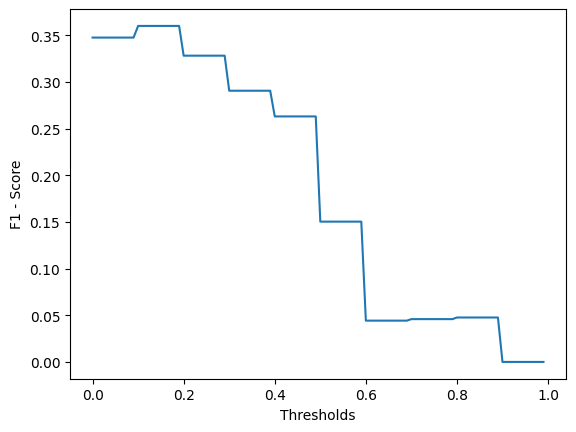

In [302]:
# Plot for finding the best threshold
best_f1_score=-1
best_thres=-1
score_arr  = []
for thres in np.arange(0,1,0.01):
    y_pred=[1 if y_proba>thres else 0 for y_proba in y_prob]
    score=fbeta_score(y_val,y_pred,beta=beta)
    if(score>best_f1_score):
        best_f1_score=score
        best_thres=thres
    score_arr.append(score)
print(best_f1_score,best_thres)
plt.xlabel("Thresholds")
plt.ylabel("F1 - Score")
plt.plot(np.arange(0,1,0.01),score_arr)

#Saving the plot
plt.savefig('images/Threshold_plot.png')

In [303]:
y_pred=[1 if y_proba>best_thres else 0 for y_proba in y_prob]
print("Classification Report\n\n",classification_report(y_val,y_pred))

Classification Report

               precision    recall  f1-score   support

           0       0.98      0.75      0.85       473
           1       0.12      0.68      0.21        25

    accuracy                           0.74       498
   macro avg       0.55      0.71      0.53       498
weighted avg       0.94      0.74      0.82       498



## Bagging Classifier

In [304]:
# Training on Bagging Classifier
if os.path.exists('./models/Bagging Classifier.pkl'):
    classifier_BC=pickle.load(open('./models/Bagging Classifier.pkl', 'rb'))
else:
    classifier_BC=BaggingClassifier(estimator=SVC(),n_estimators=10,random_state=42).fit(X_train,y_train)
print("fbeta-score for Bagging Classifier",fbeta_score(y_val,classifier_BC.predict(X_val),beta  = beta))
model_selection_dict["Bagging Classifier"] = fbeta_score(y_val,classifier_BC.predict(X_val),beta = beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,classifier_BC.predict(X_val),target_names=['not stroke','stroke']))

#Saving the model 
if not os.path.exists('./models/Bagging Classifier.pkl'):
    pickle.dump(classifier_BC, open('./models/Bagging Classifier.pkl', 'wb'))

fbeta-score for Bagging Classifier 0.47727272727272724
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.79      0.88       473
      stroke       0.17      0.84      0.29        25

    accuracy                           0.79       498
   macro avg       0.58      0.82      0.58       498
weighted avg       0.95      0.79      0.85       498



## Ratio of Majority vs Miniority Class Points

In [305]:
len(np.where(y_train_not_sampled==0)[0])/len(np.where(y_train_not_sampled==1)[0])

19.03448275862069

## Voting Ensemble

In [306]:
# Creating Custom Voting Ensemble

n_estimators=19
minority_indices=np.where(y_train_not_sampled==1)[0]
majority_indices=np.where(y_train_not_sampled==0)[0]
n=len(minority_indices)
np.random.shuffle(majority_indices)
start=0
end=n+1
voting_ensemble=[]
while(end<len(majority_indices)):
    train_data_indices=np.array(minority_indices)
    train_data_indices=np.append(train_data_indices,majority_indices[start:end])
    clf=DecisionTreeClassifier()
    clf.fit(X_train_not_sampled[train_data_indices],y_train_not_sampled[train_data_indices])
    voting_ensemble.append(clf)
    start+=n
    end+=n
train_data_indices=np.array(minority_indices)
train_data_indices=np.append(train_data_indices,majority_indices[start:])

if os.path.exists('./models/clf_DTC(Voting ensemble).pkl'):
    clf=pickle.load(open('./models/clf_DTC(Voting ensemble).pkl', 'rb'))
else:
    clf=DecisionTreeClassifier()
    clf.fit(X_train_not_sampled[train_data_indices],y_train_not_sampled[train_data_indices])
voting_ensemble.append(clf)

#Saving the model
if not os.path.exists('./models/clf_DTC(Voting ensemble).pkl'):
    pickle.dump(clf, open('./models/clf_DTC(Voting ensemble).pkl', 'wb'))

In [307]:
# Fucntion for pred_ensemble(it returns the predictions of the ensemble) and pred_proba_ensemble(it returns the probabilities of the ensemble)
def pred_ensemble(voting_ensemble,X_val):
    n=len(voting_ensemble)
    predictions=voting_ensemble[0].predict(X_val)
    for i in range(1,n):
        predictions+=voting_ensemble[i].predict(X_val)
    y_pred=[1 if pred>n/2 else 0 for pred in predictions]
    print(n)
    return y_pred


def pred_proba_ensemble(voting_ensemble,X_val):
    n=len(voting_ensemble)
    proba=voting_ensemble[0].predict_proba(X_val)
    for i in range(1,n):
        proba+=voting_ensemble[i].predict_proba(X_val)   
    proba=proba/n
    return proba

In [308]:
#Printing confusion matrix
y_pred=pred_ensemble(voting_ensemble,X_val)
print("Confusion Matrix \n\n",confusion_matrix(y_val,y_pred))

20
Confusion Matrix 

 [[316 157]
 [  2  23]]


In [309]:
# Printing classification report
print("Classification Report \n\n",classification_report(y_val,y_pred))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.67      0.80       473
           1       0.13      0.92      0.22        25

    accuracy                           0.68       498
   macro avg       0.56      0.79      0.51       498
weighted avg       0.95      0.68      0.77       498



In [310]:
# Printing Accuracy of Voting Ensemble
print("Accuracy for Voting Ensemble",accuracy_score(y_val,y_pred))
model_selection_dict["Voting Emsemble"] = fbeta_score(y_val,y_pred,beta = beta)

Accuracy for Voting Ensemble 0.6807228915662651


In [311]:
# Printing Confusion Matrix
print("Confusion Matrix \n\n",confusion_matrix(y_val,y_pred))

Confusion Matrix 

 [[316 157]
 [  2  23]]


In [312]:
# Printing fbeta score
print("fbeta_score",fbeta_score(y_val,y_pred,beta=beta))

fbeta_score 0.4107142857142857


## Support Vector Classifier

### SVC on undersampled data

In [313]:
# Training on Support Vectore Classifier
minority_indices=np.where(y_train_not_sampled==1)[0]
majority_indices=np.where(y_train_not_sampled==0)[0]
indices=np.append(minority_indices,np.random.choice(majority_indices,len(minority_indices)))
temp_X_train=X_train_not_sampled[indices]
temp_y_train=y_train_not_sampled[indices]
if os.path.exists('./models/SVC.pkl'):
    clf_svc=pickle.load(open('./models/SVC.pkl', 'rb'))
else:
    clf_svc=SVC(kernel='linear',probability=True).fit(temp_X_train,temp_y_train)
print("Confusion Matrix \n\n",confusion_matrix(y_val,clf_svc.predict(X_val)))

#Saving the SVC model
if not os.path.exists('./models/SVC.pkl'):
    pickle.dump(clf_svc, open('./models/SVC.pkl', 'wb'))

Confusion Matrix 

 [[335 138]
 [  1  24]]


In [314]:
# Printing fbeta score
print("fbeta-score for SVC is",fbeta_score(y_val,clf.predict(X_val),beta=beta))
model_selection_dict["SVC(undersampled)"] = fbeta_score(y_val,clf_svc.predict(X_val),beta = beta)

fbeta-score for SVC is 0.27901785714285715


In [315]:
# Printing classification report
print("Classification Report \n\n",classification_report(y_val,clf_svc.predict(X_val)))

Classification Report 

               precision    recall  f1-score   support

           0       1.00      0.71      0.83       473
           1       0.15      0.96      0.26        25

    accuracy                           0.72       498
   macro avg       0.57      0.83      0.54       498
weighted avg       0.95      0.72      0.80       498



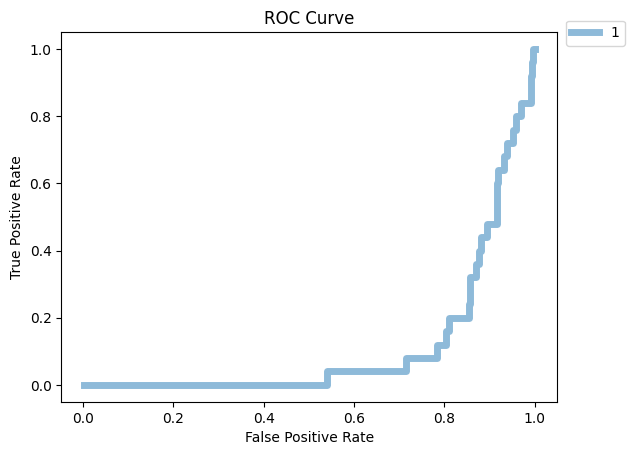

AUC:  [0.1147568710359408]


In [316]:
# Plotting ROC Curve
plot_roc_curve(clf_svc,X_val,y_val,[1])

### SVC on oversampled data

In [317]:
# Training on Support Vector Classifier with oversampled data
if os.path.exists('./models/SVC(oversampled).pkl'):
    clf_svc_over=pickle.load(open('./models/SVC(oversampled).pkl', 'rb'))
else:
    clf_svc_over=SVC(kernel='linear').fit(X_train,y_train)
model_selection_dict["SVC(oversampled)"] = fbeta_score(y_val,clf_svc_over.predict(X_val),beta = beta)

# Saving the model
if not os.path.exists('./models/SVC(oversampled).pkl'):
    pickle.dump(clf_svc_over, open('./models/SVC(oversampled).pkl', 'wb'))

In [318]:
# Printing fbeta score
print("fbeta-score for SVC is",fbeta_score(y_val,clf_svc_over.predict(X_val),beta=beta))

fbeta-score for SVC is 0.4389312977099236


## MLP Classifier

In [319]:
# Training on MLP Classifier
if os.path.exists('./models/MLP Classifier.pkl'):
    clf_mlp=pickle.load(open('./models/MLP Classifier.pkl', 'rb'))
else:
    clf_mlp=MLPClassifier(activation='logistic', alpha=0.5, learning_rate_init=0.01, max_iter=500, solver='adam').fit(X_train,y_train)
print("Classification Report \n\n",classification_report(y_val,clf_mlp.predict(X_val)))

# Saving the model
if not os.path.exists('./models/MLP Classifier.pkl'):
    pickle.dump(clf_mlp, open('./models/MLP Classifier.pkl', 'wb'))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.78      0.88       473
           1       0.18      0.92      0.30        25

    accuracy                           0.79       498
   macro avg       0.59      0.85      0.59       498
weighted avg       0.95      0.79      0.85       498



In [320]:
# Printing Confusion Matrix
print("Confusion Matrix\n\n",confusion_matrix(y_val,clf_mlp.predict(X_val)))
model_selection_dict["MLP Classifier"] = fbeta_score(y_val,clf_mlp.predict(X_val),beta = beta)

Confusion Matrix

 [[370 103]
 [  2  23]]


In [321]:
# Printing fbeta score
print("fbeta-score is",fbeta_score(y_val,clf.predict(X_val),beta=beta))

fbeta-score is 0.27901785714285715


## K-Nearest Neighbour Classifier

In [322]:
# Training on KNN Classifier and printing classification report
if os.path.exists('./models/KNN Classifier.pkl'):
    knn_clf=pickle.load(open('./models/KNN Classifier.pkl', 'rb'))
else:
    knn_clf=KNeighborsClassifier(n_neighbors=40).fit(X_train,y_train)
print("Classification Report \n\n",classification_report(y_val,knn_clf.predict(X_val)))
model_selection_dict["K-Nearest Neighbour Classifier"] = fbeta_score(y_val,knn_clf.predict(X_val),beta = beta)

if not os.path.exists('./models/KNN Classifier.pkl'):
    pickle.dump(knn_clf, open('./models/KNN Classifier.pkl', 'wb'))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.70      0.82       473
           1       0.14      0.92      0.24        25

    accuracy                           0.71       498
   macro avg       0.57      0.81      0.53       498
weighted avg       0.95      0.71      0.79       498



In [323]:
# Printing Confusion Matrix
print("Confusion Matrix\n\n",confusion_matrix(y_val,knn_clf.predict(X_val)))

Confusion Matrix

 [[329 144]
 [  2  23]]


In [324]:
# Printing fbeta score
print("fbeta_score is",fbeta_score(y_val,knn_clf.predict(X_val),beta=beta))

fbeta_score is 0.4307116104868913


## XGB Classifier

In [325]:
# Training on XGB Classifier
if os.path.exists('./models/XGB Classifier.pkl'):
    xgb_clf=pickle.load(open('./models/XGB Classifier.pkl', 'rb'))
else:
    xgb_clf=XGBClassifier(objective='binary:logistic',learning_rate=0.001).fit(X_train,y_train)
print("Confusion Matrix\n\n",confusion_matrix(y_val,xgb_clf.predict(X_val)))

# Saving the model
if not os.path.exists('./models/XGB Classifier.pkl'):
    pickle.dump(xgb_clf, open('./models/XGB Classifier.pkl', 'wb'))

Confusion Matrix

 [[375  98]
 [  3  22]]


In [326]:
# Printing classification report
print("Classfication Report\n\n",classification_report(y_val,xgb_clf.predict(X_val)))
model_selection_dict["XGB Classifier"] = fbeta_score(y_val,xgb_clf.predict(X_val),beta = beta)

Classfication Report

               precision    recall  f1-score   support

           0       0.99      0.79      0.88       473
           1       0.18      0.88      0.30        25

    accuracy                           0.80       498
   macro avg       0.59      0.84      0.59       498
weighted avg       0.95      0.80      0.85       498



In [327]:
# Printing fbeta score
print("fbeta-score is",fbeta_score(y_val,xgb_clf.predict(X_val),beta=beta))

fbeta-score is 0.5


### Parameter tuning to find best model

In [328]:
#Parameter Tuning for XGB Classifier
if os.path.exists('./models/XGB Classifier(best).pkl'):
    best_model=pickle.load(open('./models/XGB Classifier(best).pkl', 'rb'))
    best_score=fbeta_score(y_val,best_model.predict(X_val),beta=beta)
else:
    best_score=0
    best_model=0
    for w in range(2,100):
        xgb_clf_custom=XGBClassifier(learning_rate=0.01,scale_pos_weight=w).fit(X_train,y_train)
        score=fbeta_score(y_val,xgb_clf_custom.predict(X_val),beta=beta)
        if(score>best_score):
            best_score=score
            best_model=xgb_clf_custom
#Saving the best XGB Classifier
if not os.path.exists('./models/XGB Classifier(best).pkl'):
    pickle.dump(best_model, open('./models/XGB Classifier(best).pkl', 'wb'))

In [329]:
# Printing classification report
print("Classification Report \n\n",classification_report(y_val,best_model.predict(X_val)))

Classification Report 

               precision    recall  f1-score   support

           0       0.99      0.67      0.80       473
           1       0.13      0.92      0.23        25

    accuracy                           0.69       498
   macro avg       0.56      0.80      0.52       498
weighted avg       0.95      0.69      0.77       498



In [330]:
# Printing score for XGB best model
print("Best score is",best_score)
model_selection_dict["XGB Classifier"] = best_score

Best score is 0.4151624548736463


In [331]:
#Printing Confusion Matrix
print("Confusion Matrix\n\n",confusion_matrix(y_val,best_model.predict(X_val)))

Confusion Matrix

 [[319 154]
 [  2  23]]


In [332]:
xgb_classifier=best_model

## Logistic Regression

In [333]:
# Training on Logistic Regression
if os.path.exists('./models/Logistic Regression.pkl'):
    classifier_LR=pickle.load(open('./models/Logistic Regression.pkl', 'rb'))
else:
    classifier_LR = LogisticRegressionCV(cv=5, random_state = 0, max_iter=1000)
    classifier_LR.fit(X_train, y_train.ravel())
y_pred = classifier_LR.predict(X_val)

# Saving the Logistic Regression model
if not os.path.exists('./models/Logistic Regression.pkl'):
    pickle.dump(classifier_LR, open('./models/Logistic Regression.pkl', 'wb'))

In [334]:
# Printing Confusion Matrix
print("Confusion Matrix\n\n",confusion_matrix(y_val,classifier_LR.predict(X_val)))

Confusion Matrix

 [[342 131]
 [  2  23]]


In [335]:
# Printing Classification Report
print("Classification Report\n\n",classification_report(y_val,classifier_LR.predict(X_val)))
model_selection_dict["Logistic Regression"] = fbeta_score(y_val,classifier_LR.predict(X_val),beta = beta)

Classification Report

               precision    recall  f1-score   support

           0       0.99      0.72      0.84       473
           1       0.15      0.92      0.26        25

    accuracy                           0.73       498
   macro avg       0.57      0.82      0.55       498
weighted avg       0.95      0.73      0.81       498



In [336]:
# Printing fbeta score
print("fbeta-score is",fbeta_score(y_val,classifier_LR.predict(X_val),beta=beta))

fbeta-score is 0.452755905511811


## LDA

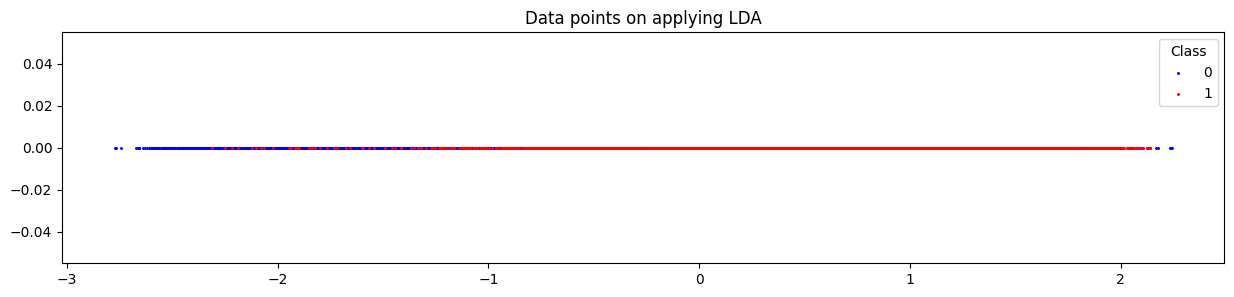

<Figure size 640x480 with 0 Axes>

In [337]:
# Training on LDAClassifier
if os.path.exists('./models/LDA.pkl'):
    lda=pickle.load(open('./models/LDA.pkl', 'rb'))
else:
    lda=LDA(n_components=1)
    lda.fit(X_train,y_train)
X_train_lda=lda.transform(X_train)
plt.figure(figsize=(15,3))
idx=np.where(y_train==0)[0]
plt.scatter(X_train_lda[idx],np.zeros(len(idx)),c='b',s=1.25,label = "0")
idx=np.where(y_train==1)[0]
plt.scatter(X_train_lda[idx],np.zeros(len(idx)),c='r',s=1.25,label="1")
plt.title("Data points on applying LDA")
plt.legend(title = "Class")
#Saving the image
plt.savefig('images/LDA.png')
plt.show()

#Saving the model
if not os.path.exists('./models/LDA.pkl'):
    pickle.dump(lda, open('./models/LDA.pkl', 'wb'))

In [338]:
# Printing Confusion Matrix
y_pred=lda.predict(X_val)
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))

Confusion Matrix

 [[341 132]
 [  2  23]]


In [339]:
# Printing Classification Report
print("Classification Report\n\n",classification_report(y_val,y_pred))
model_selection_dict["LDA"] = fbeta_score(y_val,y_pred,beta = beta)

Classification Report

               precision    recall  f1-score   support

           0       0.99      0.72      0.84       473
           1       0.15      0.92      0.26        25

    accuracy                           0.73       498
   macro avg       0.57      0.82      0.55       498
weighted avg       0.95      0.73      0.81       498



In [340]:
# Printing fbeta score
print("fbeta-score",fbeta_score(y_val,y_pred,beta=beta))

fbeta-score 0.45098039215686275


### Logistic Regression CV

In [341]:
# Training on Logistic Regression CV on LDA
if os.path.exists('./models/LDA Logistic Regression.pkl'):
    classifier_lda_LR=pickle.load(open('./models/LDA Logistic Regression.pkl', 'rb'))
else:   
    classifier_lda_LR = LogisticRegressionCV(cv=5, random_state = 0, max_iter=1000)
    classifier_lda_LR.fit(X_train_lda, y_train.ravel())
y_pred = classifier_lda_LR.predict(lda.transform(X_val))

# Saving the model
if not os.path.exists('./models/LDA Logistic Regression.pkl'):
    pickle.dump(classifier_lda_LR, open('./models/LDA Logistic Regression.pkl', 'wb'))

In [342]:
# Printing Confusion Matrix
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))
model_selection_dict["LDA(LR CV)"] = fbeta_score(y_val,y_pred,beta = beta)

# Printing Classification Report
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))

Confusion Matrix

 [[341 132]
 [  2  23]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.72      0.84       473
      stroke       0.15      0.92      0.26        25

    accuracy                           0.73       498
   macro avg       0.57      0.82      0.55       498
weighted avg       0.95      0.73      0.81       498



In [343]:
# Printing fbeta score
print("f-beta score is",fbeta_score(y_val,y_pred,beta=beta))

f-beta score is 0.45098039215686275


### SVC

In [344]:
# Training on SVC on LDA
if os.path.exists('./models/LDA SVC.pkl'):
    classifier_lda_svc=pickle.load(open('./models/LDA SVC.pkl', 'rb'))
else:
    classifier_lda_svc = SVC(kernel='linear',C=50)
    classifier_lda_svc.fit(X_train_lda, y_train.ravel())
y_pred = classifier_lda_svc.predict(lda.transform(X_val))

# Saving the model
if not os.path.exists('./models/LDA SVC.pkl'):
    pickle.dump(classifier_lda_svc, open('./models/LDA SVC.pkl', 'wb'))

In [345]:
# Printing Confusion Matrix
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))
model_selection_dict["LDA(SVC)"] = fbeta_score(y_val,y_pred,beta = beta)

# Printing Classification Report
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))

Confusion Matrix

 [[341 132]
 [  2  23]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.72      0.84       473
      stroke       0.15      0.92      0.26        25

    accuracy                           0.73       498
   macro avg       0.57      0.82      0.55       498
weighted avg       0.95      0.73      0.81       498



In [346]:
# Printing fbeta score
print("fbeta score",fbeta_score(y_val,y_pred,beta=beta))

fbeta score 0.45098039215686275


## One Class SVM

In [347]:
# Training on One Class SVM
if os.path.exists('./models/One Class SVM.pkl'):
    clf=pickle.load(open('./models/One Class SVM.pkl', 'rb'))
else:
    clf = OneClassSVM(nu=0.01, kernel="poly", gamma=1)
    clf.fit(X_train[y_train==1])
y_pred=clf.predict(X_val)

# Saving the model
if not os.path.exists('./models/One Class SVM.pkl'):
    pickle.dump(clf, open('./models/One Class SVM.pkl', 'wb'))

In [348]:
one_class_svm=clf

In [349]:
#Printing Confusion Matrix
y_pred[y_pred==-1]=0
print("Confusion Matrix\n\n",confusion_matrix(y_val,y_pred))

# Printing Classification Report
model_selection_dict["One Class SVM"] = fbeta_score(y_val,y_pred,beta = beta)
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred,target_names=['not stroke','stroke']))

Confusion Matrix

 [[124 349]
 [  1  24]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.99      0.26      0.41       473
      stroke       0.06      0.96      0.12        25

    accuracy                           0.30       498
   macro avg       0.53      0.61      0.27       498
weighted avg       0.95      0.30      0.40       498



In [350]:
# Printing fbeta score
print('fbeta score is',fbeta_score(y_val,y_pred,beta=beta))

fbeta score is 0.2536997885835095


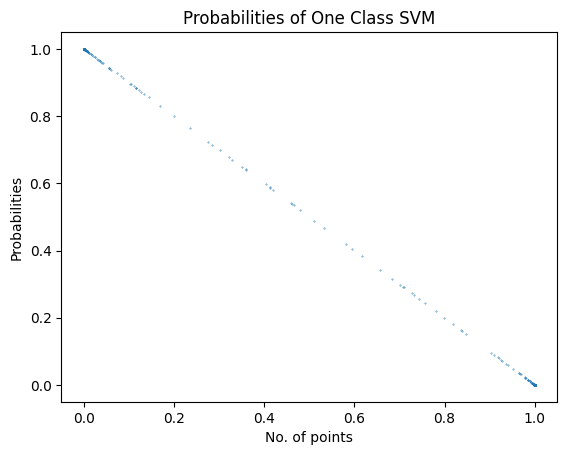

In [351]:
# function for platt_scaling

def platt_scale(oc_svm, X, train_size, cv_size):
	# Get SVM predictions
	y_pred = oc_svm.predict(X)
		
	# Split the data and SVM labels
	X_train, _, y_train, _ = tts(X, y_pred, train_size=train_size)

	# Train using logistic regression with cross-validation 
	lr =LogisticRegressionCV(cv=cv_size,max_iter=1000)
	lr.fit(X_train, y_train)

	return lr.predict_proba(X)


y_pred=platt_scale(clf,X_val,0.7,5)
plt.scatter(y_pred[:,0],y_pred[:,1],s=0.1)
plt.title("Probabilities of One Class SVM")
plt.xlabel("No. of points")
plt.ylabel("Probabilities")
# Saving the image
plt.savefig('images/Probabilities One Class SVM.png')
plt.show()


Text(0.5, 1.0, 'Probabilities predicted by one class SVM for false positive points')

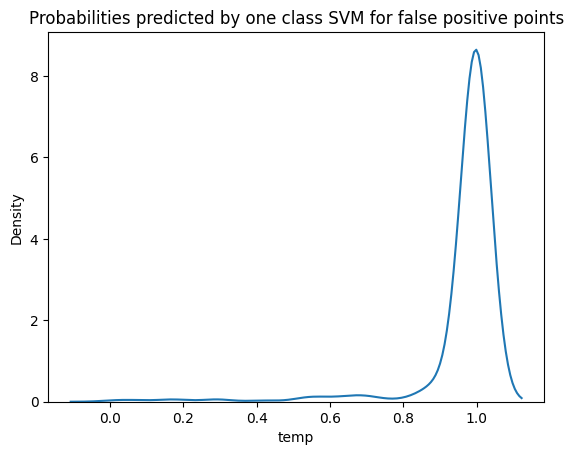

In [352]:
# Probabilities predicted by one class SVM for false positive points

temp=[]
pred=clf.predict(X_val)
for i in range(len(pred)):
    if(pred[i]==1 and y_val[i]==0):
        temp.append(y_pred[i,1])
        
temp.sort()
# plt.scatter(np.arange(len(temp)),temp)

temp=pd.DataFrame(temp,columns=['temp'])
sns.kdeplot(data=temp,x='temp')
plt.title('Probabilities predicted by one class SVM for false positive points')
# temp

## Neural Network

In [353]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam

# Defining custom loss function
def custom_loss(y_true, y_pred):
    #Calculating FP,FN,TP,TN
    y_true = K.cast(y_true, dtype=K.floatx())
    FP = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    FN = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TN = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))

    #cross entropy loss
    cross_entropy = K.binary_crossentropy(y_true, y_pred)
    weights_FP = 1.0
    weights_FN = 2.0
    weights_TP = 1.0
    weights_TN = 1.0

    #Calculating loss
    loss = (FP * weights_FP + FN * weights_FN + (1 - TP) * weights_TP + TN * weights_TN) * cross_entropy

    #tf.mean
    loss = K.mean(loss)
    return loss

if os.path.exists('./models/Brain_stroke_model.h5'):
    model = tf.keras.models.load_model('./models/Brain_stroke_model.h5', custom_objects={'custom_loss': custom_loss})
    print("Loading Saved Model")
else:
    model = Sequential()
    model.add(Dense(1024, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    learning_rate = 0.000001
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss=custom_loss, optimizer=optimizer, metrics=['accuracy'])

    # train the model
    for i in range(300):
        model.fit(X_train, y_train, epochs=5, batch_size=128)
        # y_pred = model.predict(X_test)
        # y_pred_classes = (y_pred > 0.5).astype(int)
        # cm = confusion_matrix(y_test, y_pred_classes)
        # print(cm)
        # report = classification_report(y_test, y_pred_classes)
        # print(report)
    
    for i in range(30):
        model.fit(X_train, y_train, epochs=5, batch_size=40)
        # y_pred = model.predict(X_test)
        # y_pred_classes = (y_pred > 0.5).astype(int)
        # cm = confusion_matrix(y_test, y_pred_classes)
        # print(cm)
        # report = classification_report(y_test, y_pred_classes)
        # print(report)

Loading Saved Model


In [354]:
# Saving the model
if not os.path.exists('./models/Brain_stroke_model.h5'):
    model.save('./models/Brain_stroke_model.h5')

In [355]:
Nueral_net_custom=model

In [356]:
# Confusion Matrix and Classification Report, fbeta score

y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix\n\n",cm)
report = classification_report(y_val, y_pred_classes)
print("Classififcation Report\n\n",report)
print("fbeta score is",fbeta_score(y_val,y_pred_classes,beta=beta))
model_selection_dict["Neural Network with custom loss"]=fbeta_score(y_val,y_pred_classes,beta=beta)

16/16 [==============================] - 0s 4ms/step
Confusion Matrix

 [[342 131]
 [  3  22]]
Classififcation Report

               precision    recall  f1-score   support

           0       0.99      0.72      0.84       473
           1       0.14      0.88      0.25        25

    accuracy                           0.73       498
   macro avg       0.57      0.80      0.54       498
weighted avg       0.95      0.73      0.81       498

fbeta score is 0.43478260869565205


## Extras (Miscellaneous)

20


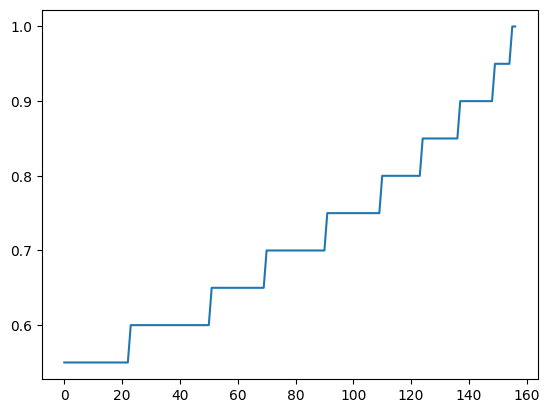

In [357]:
# Plotting the  pred_proba_ensemble(voting_ensemble,X_val) probabilities 
y_proba_ensemble=pred_proba_ensemble(voting_ensemble,X_val)
y_pred_ensemble=pred_ensemble(voting_ensemble,X_val)
temp=[]
for i in range(len(y_val)):
    if(y_val[i]==0 and y_pred_ensemble[i]==1):
        temp.append(y_proba_ensemble[i,1])
        
temp.sort()
plt.plot(np.arange(len(temp)),temp)


In [358]:
# function to plot roc curve for ensemble

def plot_roc_curve_ensemble(clf,X,y,classes):
    y_probas=pred_proba_ensemble(clf,X)
    best_thres=0
    best_score=0
    auc_s=[]
    for idx,class_no in enumerate(classes):
        y_true=np.where(y==class_no,1,0)
        y_probs=y_probas[:,idx]
        thresholds=np.sort(y_probs)[::-1]
        tpr=[]
        fpr=[]
        for thres in thresholds:
            y_pred=np.where(y_probs>=thres,1,0)
            tn,fp,fn,tp=confusion_matrix(y_true,y_pred).ravel()
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
            if(best_score<(tp/(tp+fn)-fp/(fp+tn))):
                best_score=(tp/(tp+fn)-fp/(fp+tn))
                best_thres=thres
        auc=np.trapz(tpr,fpr)
        auc_s.append(auc)
        plt.plot(fpr,tpr,label=class_no,alpha=0.5,lw=5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    print("AUC: ",auc_s)
    return best_thres

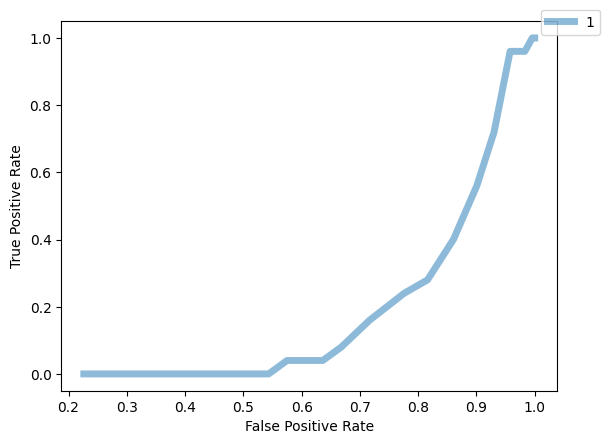

AUC:  [0.15052854122621567]


In [359]:
thres_ensemble=plot_roc_curve_ensemble(voting_ensemble,X_val,y_val,[1])

In [360]:
# Finding the best_f1_score and best_thres

best_f1_score=-1
best_thres=-1
for thres in np.arange(0,1,0.01):
    temp=[1 if y_proba>thres else 0 for y_proba in y_proba_ensemble[:,1]]
    score=f1_score(y_val,temp)
    if(score>best_f1_score):
        best_f1_score=score
        best_thres=thres
        
print(best_f1_score,best_thres)

0.2830188679245283 0.7000000000000001


In [361]:
# Plotting the confusion matrix and classification report for ensemble
y_pred_ensemble=[1 if y_proba>(best_thres)
                 else 0 for y_proba in y_proba_ensemble[:,1]]
print(confusion_matrix(y_val,y_pred_ensemble))
print(" \n\n Classification Report \n\n",classification_report(y_val,y_pred_ensemble,target_names=['not stroke','stroke']))

[[407  66]
 [ 10  15]]
 

 Classification Report 

               precision    recall  f1-score   support

  not stroke       0.98      0.86      0.91       473
      stroke       0.19      0.60      0.28        25

    accuracy                           0.85       498
   macro avg       0.58      0.73      0.60       498
weighted avg       0.94      0.85      0.88       498



##Best Model Selection

In [362]:
# Function to sort the dictionary by values
def sort_dict_by_values(dict):
    sorted_dict = {}
    sorted_keys = sorted(dict, key=dict.get)
    for key in sorted_keys:
        sorted_dict[key] = dict[key]
    return sorted_dict

In [363]:
# Printing the sorted model_selection_dict
sorted_model_selection_dict=sort_dict_by_values(model_selection_dict)
sorted_model_selection_dict


{'Balanced Bagging Classifier': 0.15037593984962405,
 'One Class SVM': 0.2536997885835095,
 'Naive Bayes(Complement)': 0.3508771929824561,
 'Voting Emsemble': 0.4107142857142857,
 'XGB Classifier': 0.4151624548736463,
 'K-Nearest Neighbour Classifier': 0.4307116104868913,
 'Neural Network with custom loss': 0.43478260869565205,
 'SVC(oversampled)': 0.4389312977099236,
 'LDA': 0.45098039215686275,
 'LDA(LR CV)': 0.45098039215686275,
 'LDA(SVC)': 0.45098039215686275,
 'Logistic Regression': 0.452755905511811,
 'SVC(undersampled)': 0.4580152671755725,
 'Bagging Classifier': 0.47727272727272724,
 'MLP Classifier': 0.5088495575221239}

In [364]:

best_model_name = max(sorted_model_selection_dict, key=sorted_model_selection_dict.get)
print("Best model Name:", best_model_name)

Best model Name: MLP Classifier


In [367]:
model_name=best_model_name
best_clf_final = 0
if(model_name=="Balanced Bagging Classifier"):
    best_clf_final=classifier_BBC
elif(model_name=="Bagging Classifier"):
    best_clf_final=classifier_BC
elif(model_name=="K-Nearest Neighbour Classifier"):
    best_clf_final=knn_clf
elif(model_name=="LDA"):
    best_clf_final=lda
elif(model_name=="LDA(LR CV)"):
    best_clf_final=classifier_lda_LR
elif(model_name=="LDA(SVC)"):
    best_clf_final=classifier_lda_LR
elif(model_name=="Logistic Regression"):
    best_clf_final=classifier_LR
elif(model_name=="MLP Classifier"):
    best_clf_final=clf_mlp
elif(model_name=="Naive Bayes(Complement)"):
    best_clf_final=CNB_clf
elif(model_name=="Nueral Network with custom loss"):
    best_clf_final=Nueral_net_custom
elif(model_name=="One Class SVM"):
    best_clf_final=one_class_svm
elif(model_name=="SVC(oversampled)"):
    best_clf_final=clf_svc_over
elif(model_name=="SVC(undersampled)"):
    best_clf_final=clf_svc
elif(model_name=="Voting Emsemble"):
    best_clf_final=voting_ensemble
elif(model_name=="XGB Classifier"):
    best_clf_final=xgb_classifier

##Best model Evaluation on testing dataset

In [368]:
best_clf_final.score(X_test,y_test)

0.8014042126379137

In [369]:
y_pred=best_clf_final.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[760 188]
 [ 10  39]]


In [371]:
print(fbeta_score(y_test,y_pred,beta=beta))

0.46099290780141844


In [372]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88       948
           1       0.17      0.80      0.28        49

    accuracy                           0.80       997
   macro avg       0.58      0.80      0.58       997
weighted avg       0.95      0.80      0.86       997



##User Input

In [365]:
#Predicting on user input
# check if user_input.json

if os.path.exists('./user_input.json'):
    with open('./user_input.json') as f:
        user_input = json.load(f)
    inp_array=(np.array(eval(user_input)))
    
    inp_array=inp_array.reshape((1,-1))
   
    
    model_name=best_model_name
    stroke_pred = 0
    if(model_name=="Balanced Bagging Classifier"):
        stroke_pred=classifier_BBC.predict(inp_array)
    elif(model_name=="Bagging Classifier"):
        stroke_pred=classifier_BC.predict(inp_array)
    elif(model_name=="K-Nearest Neighbour Classifier"):
        stroke_pred=knn_clf.predict(inp_array)
    elif(model_name=="LDA"):
        stroke_pred=lda.predict(inp_array)
    elif(model_name=="LDA(LR CV)"):
        stroke_pred=classifier_lda_LR.predict(inp_array)
    elif(model_name=="LDA(SVC)"):
        stroke_pred=classifier_lda_LR.predict(inp_array)
    elif(model_name=="Logistic Regression"):
        stroke_pred=classifier_LR.predict(inp_array)
    elif(model_name=="MLP Classifier"):
        stroke_pred=clf_mlp.predict(inp_array)
    elif(model_name=="Naive Bayes(Complement)"):
        stroke_pred=CNB_clf.predict(inp_array)
    elif(model_name=="Nueral Network with custom loss"):
        stroke_pred=Nueral_net_custom.predict(inp_array)
    elif(model_name=="One Class SVM"):
        stroke_pred=one_class_svm.predict(inp_array)
    elif(model_name=="SVC(oversampled)"):
        stroke_pred=clf_svc_over.predict(inp_array)
    elif(model_name=="SVC(undersampled)"):
        stroke_pred=clf_svc.predict(inp_array)
    elif(model_name=="Voting Emsemble"):
        stroke_pred=pred_ensemble(voting_ensemble,inp_array)
    elif(model_name=="XGB Classifier"):
        stroke_pred=xgb_classifier.predict(inp_array)
    else:
        print("Invalid model name")
    #save input as well as output
    with open("./user_inp_output","a") as file:
        file.write("User Input:-")
        file.write(str(inp_array))
        file.write('\n')
        file.write("Prediction:-")
        file.write(str(stroke_pred))
        file.write('\n')
        file.write('\n')